# Случайные процессы. Прикладной поток.
## Практическое задание 6

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 6"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `6.N.ipynb` и `6.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке могут быть запущены функции, которые отвечают за генерацию траекторий винеровского процесса.

------------------

In [2]:
import pandas as pd
from io import StringIO
from datetime import datetime
import re
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

from bisect import bisect_right
from bisect import bisect_left

%matplotlib inline

### 1. Генерация винеровского процесса

Генерировать траектории винеровского процесса можно двумя способами:

1. На отрезке $[0, 1]$ траектория генерируется с помощью функций Шаудера. Описание данного метода было рассказано на лекции. Его можно найти так же в книге *А.В. Булинский, А.Н. Ширяев - Теория случайных процессов*.

2. На отрезке $[0, \pi]$ траекторию можно с помощью следующей формулы
$$W_t = \frac{\xi_0 t}{\sqrt{\pi}} +\sqrt{\frac{2}{\pi}}\sum\limits_{k=1}^{+\infty} \frac{\sin(kt)}{k} \xi_k,$$
где $\{\xi_n\}$ --- независимые стандартные нормальные случайные величины.

Траектория для $\mathbb{R}_+$ генерируется с помощью генерирования отдельных траекторий для отрезков длины 1 или $\pi$ (в зависимости от метода) с последующим непрерывным склеиванием.

Генерацию траекторий одним из этих способов вам нужно реализовать. Ваш вариант можете узнать из файла с распределением.

Напишите класс, который будет моделировать винеровский процесс.
Из бесконечной суммы берите первые $n$ слагаемых, где число $n$ соответствует параметру `precision`.
Интерфейс должен быть примерно таким (подчеркивания обязательны!):

---
#### Часть `Калиниченко Ольги`

In [3]:
class WinerProcess_1:
    def __init__(self, precision=10000):
        self.n = precision
        self.xi = []
        self.start = []
        self.end = []
        self.ns = np.linspace(0, 
                              int(np.log(precision)) + 1,
                              int(np.log(precision)) + 2)
        self.midval = 2 ** (-self.ns / 2 - 1)
        self.lens = 2 ** (-self.ns - 1)
        
    def _add_one(self):
        if len(self.xi):
            start = self.end[-1]
        else:
            start = 0
        self.xi += [np.array(sps.norm.rvs(size=self.n))]
        self.start += [start]
        self.end += [start + self.xi[-1][0]]
            
    def _create(self, t):
        while len(self.xi) < t + 1:
            self._add_one()
    
    def _get(self, xi, t):
        ks = (2 ** self.ns * (t + 1)).astype(int)
        aa = 2**(-self.ns) * ks - 1
        mid = aa + 2 ** (-self.ns - 1)
        ans = np.zeros(len(mid))
        ans[t < mid] = self.midval[t < mid] * \
                       (t - aa[t < mid])
        ans[t >= mid] = self.midval[t>=mid] *       \
                        (1 - (t - mid[t >= mid]) /  \
                         self.lens[t>=mid])
        
        while (ks[-1] >= self.n):
            ks = ks[:-1]
            ans = ans[:-1]
        res = t * xi[0] + (xi[ks] * ans).sum()
        return res
        
    
    def __getitem__(self, times):
        if type(times) is float:
            times = [times]
        times = np.array(times)
        seg = times.astype(int)
        self._create(seg.max())
        return [self.start[int(times[i])] + \
                self._get(self.xi[int(times[i])], times[i] - \
                          int(times[i])) \
                for i in range(len(times))]

---
#### Часть `Крохалева Арсения`

Заметим, что в точке $\pi$ значение $$W_t = \frac{\xi_0 \pi}{\sqrt{\pi}} +\sqrt{\frac{2}{\pi}}\sum\limits_{k=1}^{+\infty} \frac{\sin(k \pi)}{k} \xi_k = \sqrt{\pi} \xi_0$$

Следовательно для каждой части $\left[p \pi, p \pi + \pi\right]$ будем генерировать свой процесс, и непрерывно склеивать со значением в точке $$W_{p \pi} = \sqrt{\pi} \sum_{i = 0}^{p} \xi_0^{i} $$

In [4]:
class WinerProcess_2:
    def _calculate_part(self, num):
        # если записана пустота
        if len(self.xis[num]) == 0:
            # то заполним новыми значениями
            self.xis[num] = sps.norm.rvs(size=self.precision)
            
    def _continue_to_part(self, num):
        ''' Достроит текущий процесс до отрезка [0, (num + 1) * pi] '''
        # проверим, необходима ли генерация новых значений
        if len(self.xis) < num + 1:
            # сгенерируем новые xi_0
            new_xis = sps.norm.rvs(size=(num + 1 - len(self.xis)))
            # запомним их
            self.zero_xis.extend(new_xis)
            # пока положим пустоту в значения остальных xi
            self.xis.extend([[]] * len(new_xis))
            # досчитаем значения на концах
            self.sums.extend(self.sums[len(self.sums) - 1] + \
                             np.cumsum(new_xis))
            
    def __init__(self, precision=10000):
        # Массив для сохранения значений случайных величин для кадого из частей
        self.xis = []
        self.zero_xis = []
        # Массив сумм нулевых xi из каждой части
        self.sums = [0] 
        self.precision = precision
        
    def __getitem__(self, times):
        times = np.array(times)
        # Номер части можно вычислить просто поделив на pi
        parts = np.floor(times / np.pi).astype('int')
        # Достроим наш процесс ровно до туда, до куда это необходимо в данный момент
        self._continue_to_part(np.max(parts))
        
        # Вспомогательный массив для нахождения суммы в дальнейшем
        nums = np.arange(1, self.precision + 1)
        # Итоговый массив со значениями в точках 'times'
        w = []
        for i in range(len(times)):
            self._calculate_part(parts[i])
            
            # Вычислим коэффиценты в сумме по формуле
            local_time = times[i] - parts[i] * np.pi
            coefs = np.sin(nums * local_time) / nums
            # Сохраним ответ
            w.append(np.sqrt(np.pi) * \
                     self.sums[parts[i]] + \
                     self.zero_xis[parts[i]] * \
                     local_time / \
                     np.sqrt(np.pi) + \
                     np.sqrt(2 / np.pi) * \
                     np.sum(coefs * self.xis[parts[i]]))
        return np.array(w)

---

* Экземпляр класса должен представлять некоторую траекторию винеровского процесса. Это означает, что один и тот же экземпляр класса для одного и того же момента времени должен возвращать одно и тоже значение. Разные экземпляры класса --- разные (п.н.) траектории.

* Метод `__init__` (конструктор) должен запоминать число слагаемых в сумме (`precision`), а также (может быть) генерировать необходимые случайные величины для начального отрезка.

* Метод `__getitem__` должен принимать набор моментов времени и возвращать значения траектории винеровского процесса в эти моменты времени. При необходимости можно сгенерировать новые случайные величины. Используйте то, что запись `x.__getitem__(y)` эквивалентна `x[y]`.

* Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`.

* Внимательно проверьте отсутствие разрывов траектории в точках, кратных $\pi$.

* Имена любых вспомогательных методов должны начинаться с одного подчеркивания.

* В реализации желательно комментировать (почти) каждую строку кода. Это даже больше поможет вам, чем нам при проверке.

Сгенерируйте траекторию винеровского процесса и постройте ее график. Сгенерируйте еще одну траекторию и постройте график двумерного винеровского процесса. Графики должны быть похожими на графики с семинара.

Для начала построим траекторию первого процесса

In [100]:
w1 = WinerProcess_2()

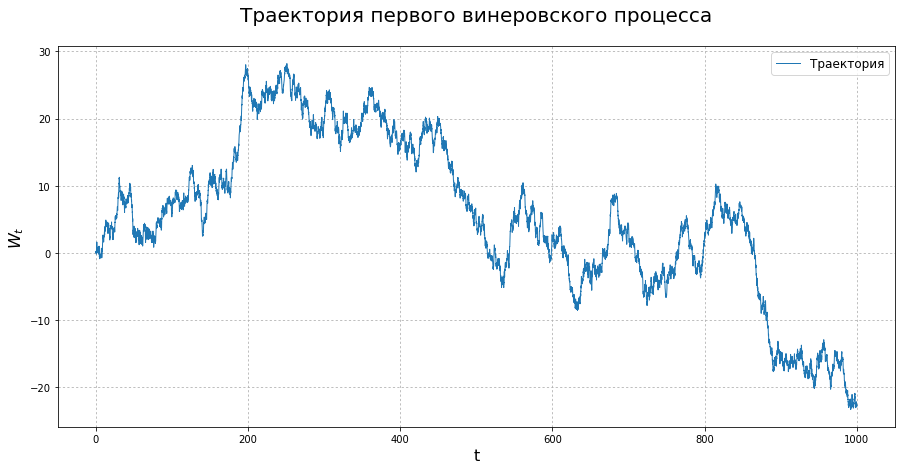

In [23]:
plt.figure(figsize=(15, 7))

times = np.linspace(0, 1000, 10000)
    
plt.plot(times, w1[times], label="Траектория", lw=1)
plt.title("Траектория первого винеровского процесса", 
          y=1.05, fontsize=20)

plt.legend(fontsize=12, loc='best')
plt.xlabel("t", fontsize=16)
plt.ylabel("$W_t$", fontsize=16)
plt.grid(ls=':')
plt.show()

Теперь создадим второй процесс и построем двумерную траекторию

In [18]:
w2 = WinerProcess_2()

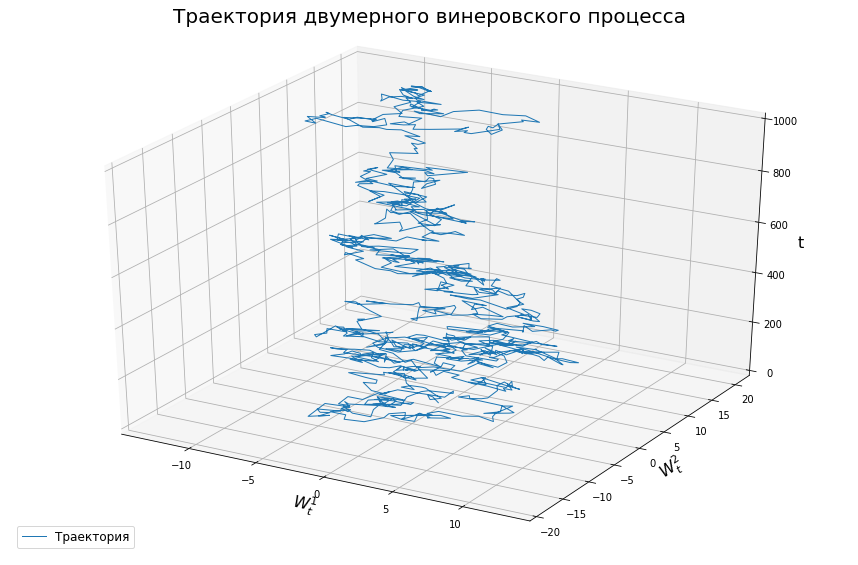

In [114]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(w1[times], w2[times], times, label="Траектория", lw=1)

plt.title("Траектория двумерного винеровского процесса", 
          y=1.05, fontsize=20)

plt.legend(fontsize=12, loc='lower left')
ax.set_xlabel("$W_t^1$", fontsize=16)
ax.set_ylabel("$W_t^2$", fontsize=16)
ax.set_zlabel("t", fontsize=16)
plt.show()

Для наглядности изобразим его проекцию без времени

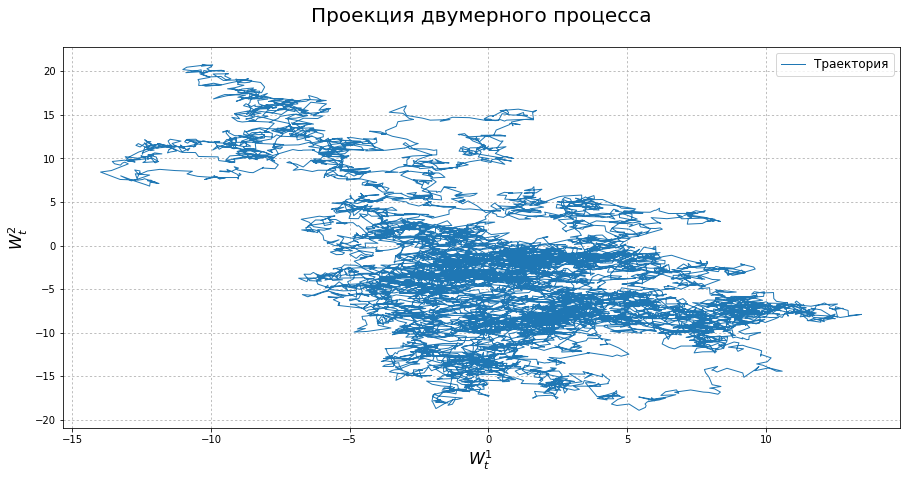

In [121]:
plt.figure(figsize=(15, 7))

times = np.linspace(0, 1000, 10000)

plt.plot(w1[times], w2[times], label="Траектория", lw=1)
plt.title("Проекция двумерного процесса", 
          y=1.05, fontsize=20)

plt.legend(fontsize=12, loc='best')
plt.xlabel("$W_t^1$", fontsize=16)
plt.ylabel("$W_t^2$", fontsize=16)
plt.grid(ls=':')
plt.show()

Допустим, для исследования свойств траекторий винеровского процесса нам нужно сгенерировать траекторию с хорошей точностью до достаточно большого значения $t$.
Какие проблемы могут возникнуть при использовании реализованного класса?
Для этого попробуйте запустить следующий код.

In [39]:
Wt = WinerProcess_2()
t = np.linspace(0, 10 ** 7, 10 ** 5)
values = Wt[t]

Ушел в SWAP, занял $\sim 8.5$ гб на диске, но досчитал

In [40]:
len(values)

100000

Опишите подробно причину проблемы, которая в данном случае возникает.

Требуется сгенерировать $10^5$ точек на интервале $\left[0, 10^7\right]$, скорее всего каждая точка попадет в свой интервал длиной $\pi$, тогда программе придется сгенерировать (с учетом точности $10^4$) $\sim 10^4 \cdot 10^5 = 10^9$ это (если float занимает $8$ байт) $\sim 8 \cdot 10^9$ байт или $\sim 7.5$ гигабайт памяти

Для избавления от таких проблем реализуйте следующую функцию:

---
#### Часть `Калиниченко Ольги`

In [43]:
def winer_process_path_1(end_time, step, precision=10000):
    def _get(xi, t, color):
        '''По моменту времени возвращает значение траектории винероского
        процесса в точке t, где t на отрезке [0, 1]'''
        ks = (2 ** nss * (t + 1)).astype(int) # номера случайных величин, домножаемых
        # на ненулевое значение функции Шаудера
        aa = 2**(-nss) * ks - 1 # начала отрезочков с ненулевой функцией Шаудера
        mid = aa + 2 ** (-nss - 1) # середины отрезочков
        ans = np.zeros(len(mid)) # функция Шаудера в точке t для отрезочков
        ans[t < mid] = midval[t < mid] * ((t - aa[t < mid])) # если t левее середины
        ans[t >= mid] =  midval[t>=mid]* (1 - (t - mid[t >= mid]) / lens[t >= mid]) # правее
        while (ks[-1] >= precision): # выполняется О(1) раз,
            # убираем с хвоста не попавшие в precision номера
            ks = ks[:-1]
            ans = ans[:-1]
        res = 0 # ответ для точки, не включая случайную величину, умножающуюся на функцию Шаудера№0
        for (i, el) in enumerate(ks): # перебираем индексы величин
            if used[el] != color: # проверяем, было ли уже посчитано в данном отрезке
                used[el] = color # пишем номер отрезка
                index[el] = xiscur[0] # индекс в массиве сгенерированных величин
                xiscur[0] += 1
            # обновление ответа
            res += xi[index[el]] * ans[i]
        return res
   
    # Моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # Сюда запишите значения траектории в моменты времени times
    values = np.zeros_like(times).astype(float)
   
    # отрезки длины 1, куда попадают времена
    seg, counts = np.unique(times.astype(int), return_counts=True)
    #index = dict(zip(seg, np.arange(0, len(times), 1))) # сопоставим им номера от 1 до их кол-ва
   
    #xis = [dict() for j in range(len(seg))] # тут будут жить случайные величины для отрезочков
    xis2 = sps.norm.rvs(size=(10000)) # буфер случайных величин
    xiscur = [0] # позиция в буфере, массив, чтобы можно было использовать в функции
    deltas = sps.norm.rvs(size=len(seg)) # разницы значений тректории в концах отрезков
    begs = np.append(np.zeros(1), np.cumsum(deltas)) # начала отрезков
    nss = np.linspace(0, int(np.log(precision))+1, int(np.log(precision))+2)
    # 1/ 2**(длины отрезочков)
   
    midval = 2 ** (-nss / 2 - 1) # значение ф-и Шаудера в середине
    lens = 2 ** (-nss - 1) # длины отрезков
    prev = -1
   
    ind2 = -1 # номер отрезка по порядку
    used = np.zeros(precision)
    index = np.zeros(precision).astype(int)
    for i in range(len(times)):
        # номер отрезка
        ind = int(times[i])
        if ind != prev:
            prev = ind
            ind2 += 1
            xi = sps.norm.rvs(size=(len(nss) * counts[ind2]))
            xiscur[0] = 0
        # ответ, отдельно обрабатываем 0ю функцию Шаудера
        values[i] = begs[ind2] + (times[i] - ind) * deltas[ind2] + _get(xi, times[i] - ind, ind2+1)
 
 
    return times, values

---
#### Часть `Крохалева Арсения`

In [44]:
def winer_process_path_2(end_time, step, precision=10000):
    # Моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # Сюда запишите значения траектории в моменты времени times
    values = np.zeros_like(times)
    
    # Номер части можно вычислить просто поделив на pi
    parts = np.floor(times / np.pi).astype('int')
    # Сгенерируем xi_0 и посчитаем значения на концах
    zero_xis = sps.norm.rvs(size=(np.max(parts) + 1))
    sums = [0]
    sums.extend(np.cumsum(zero_xis))

    # Вспомогательный массив для нахождения суммы в дальнейшем
    nums = np.arange(1, precision + 1)
    prev_part = 0
    xis = sps.norm.rvs(size=precision)
    for i in range(len(values)):
        if prev_part != parts[i]:
            xis = sps.norm.rvs(size=precision)
        prev_part = parts[i]
        
        # Вычислим коэффиценты в сумме по формуле
        local_time = times[i] - parts[i] * np.pi
        coefs = np.sin(nums * local_time) / nums
        # Сохраним ответ
        values[i] = (np.sqrt(np.pi) * \
                     sums[parts[i]] + \
                     zero_xis[parts[i]] * \
                     local_time / \
                     np.sqrt(np.pi) + \
                     np.sqrt(2 / np.pi) * \
                     np.sum(coefs * xis))

    return times, values

---

Проверим теперь как это сработает для траектории с большим значением $t$ и достаточно большой точностью

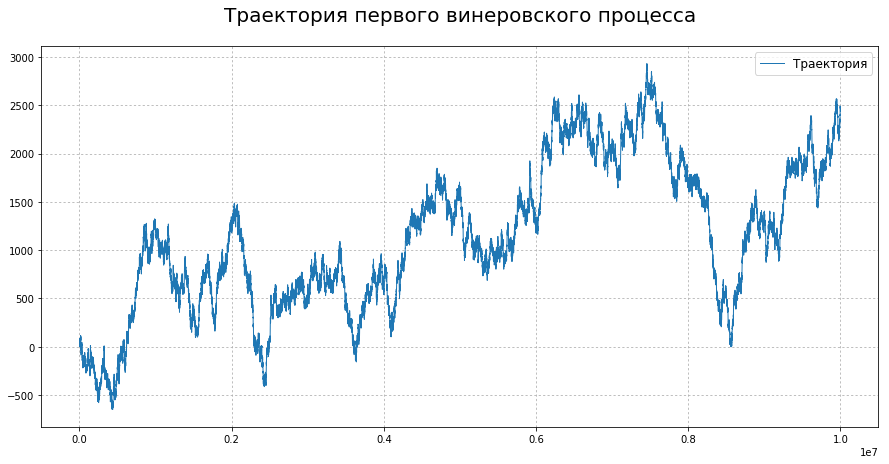

In [33]:
plt.figure(figsize=(15, 7))

times, values = winer_process_path_2(10**7, 100)
    
plt.plot(times, values, label="Траектория", lw=1)
plt.title("Траектория первого винеровского процесса", 
          y=1.05, fontsize=20)

plt.legend(fontsize=12, loc='best')
plt.xlabel("t", fontsize=16)
plt.ylabel("$W_t$", fontsize=16)
plt.grid(ls=':')
plt.show()

Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`. Внутри этой функции можно реализовать вспомогательную функцию.

### 2. Исследования

**Следующая часть работы делается в паре.**

Для каждого их двух способов генерация траектрии винеровского процесса постройте таблицу $3 \times 3$ из графиков траекторий винеровского процесса.
По вертикали изменяйте количество $n$ используемых слагаемых в сумме ($n=10; 100; 1000$), по горизонтали --- длину отрезка, на котором генерируется винеровский процесс (использовать отрезки $[0, 10], [0, 1], [0, 0.1]$).
Обратите внимание, что от размера сетки зависит только точность отображения функции на графике, а не сама функция, поэтому сетку нужно выбирать достаточно мелкой.

---
#### Часть `Калиниченко Ольги`

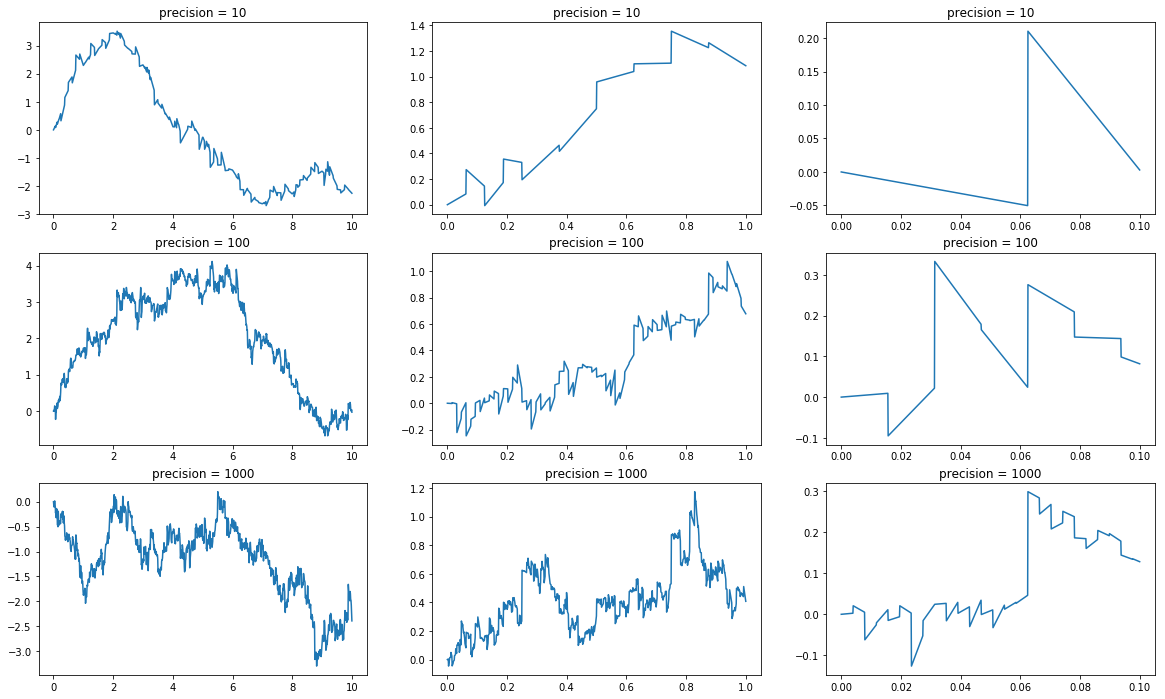

In [38]:
plt.figure(figsize=(20, 12))
for i, precision in enumerate([10, 100, 1000]):
    for j, max_time in enumerate([10, 1, 0.1]):
        t = np.linspace(0, max_time, 1000)
        values = WinerProcess_1(precision=precision)[t]
        
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(t, values)
        plt.title('precision = %d' % precision)
plt.show()

Какие выводы можно сделать про каждый способ генерации?

**Способ 1:** Посколько precision задано для отрезка длины 1, то при фиксированной длине интервала,т.е. при фиксированном кол-ве точек, попадающих в отрезок длины 1, чем меньше точность, тем меньше отличаются значения, потому что при малой точности многие отрезки, на которых функция Хаара ненулевая, совпадут для разных точек.
При фиксированной точности для отрезка 1 общая точность зависит от длины интервала - чем больше интервал, тем больше точность. Это так, потому что при попадании в один отрезок значения в точках больше похожи из-за того что они могут попасть в разные маленькие отрезки. А в разных отрезках этого не происходит, поэтому значения могут больше отличаться.

---
#### Часть `Крохалева Арсения`

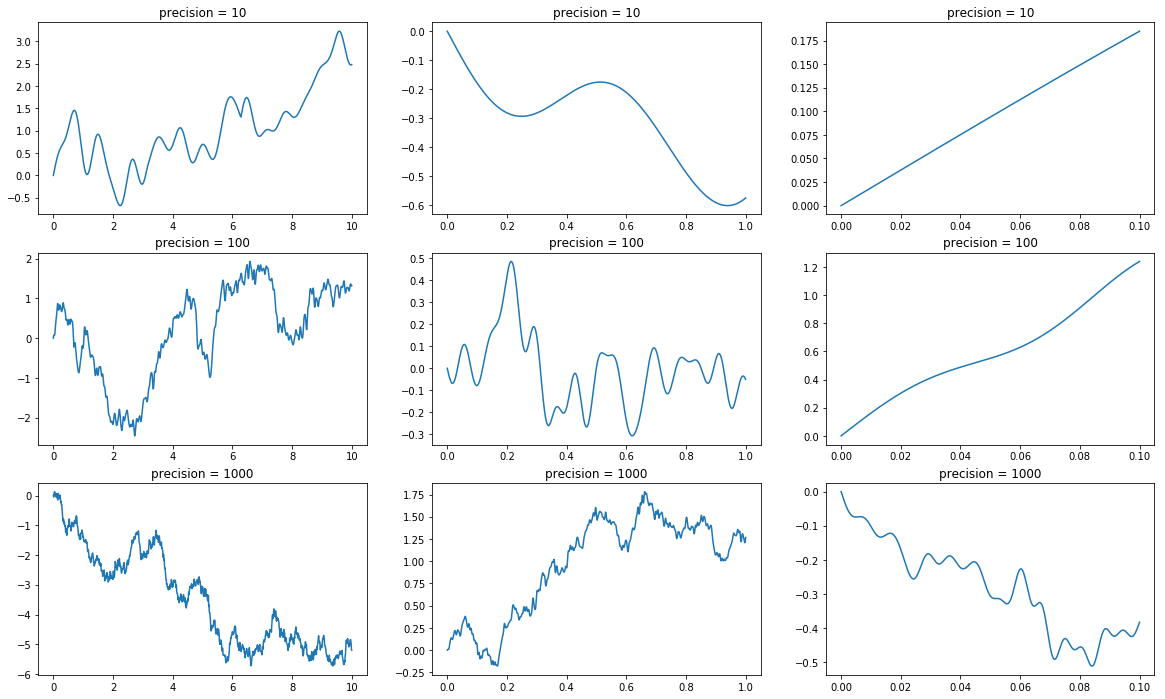

In [36]:
plt.figure(figsize=(20, 12))
for i, precision in enumerate([10, 100, 1000]):
    for j, max_time in enumerate([10, 1, 0.1]):
        t = np.linspace(0, max_time, 1000)
        values = WinerProcess_2(precision=precision)[t]
        
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(t, values)
        plt.title('precision = %d' % precision)
plt.show()

Какие выводы можно сделать про каждый способ генерации?

**Способ 2:** Поскольку мы ограгичили бесконечный ряд до конечного числа слагаемых, то получаем лишь гладкую функцию, сходящуюся к искомой траектории и чем больше значение `precision` тем менее траектория похожа на функцию $sin$

---

Сравните два способа генерации по времени работы.

In [45]:
%time times, values = winer_process_path_1(100000, 0.1)

CPU times: user 1min 22s, sys: 1.05 s, total: 1min 23s
Wall time: 1min 26s


In [46]:
%time times, values = winer_process_path_2(100000, 0.1)

CPU times: user 4min 16s, sys: 1.94 s, total: 4min 18s
Wall time: 4min 22s


Постройте графики полученных траекторий для каждого способа? Отличаются ли траектории визуально?

Какие можно сделать выводы из сравнения двух способов генерации?

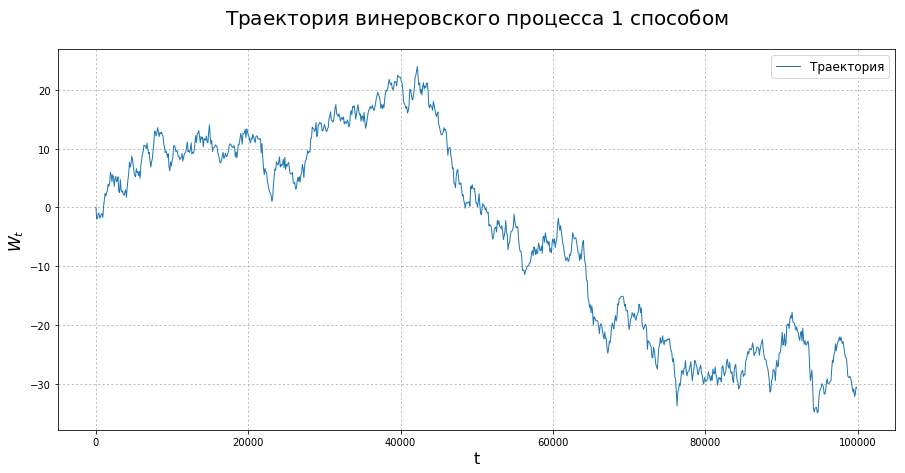

In [75]:
plt.figure(figsize=(15, 7))

times, values = winer_process_path_1(100000, 100)
    
plt.plot(times, values, label="Траектория", lw=1)
plt.title("Траектория винеровского процесса $1$ способом", 
          y=1.05, fontsize=20)

plt.legend(fontsize=12, loc='best')
plt.xlabel("t", fontsize=16)
plt.ylabel("$W_t$", fontsize=16)
plt.grid(ls=':')
plt.show()

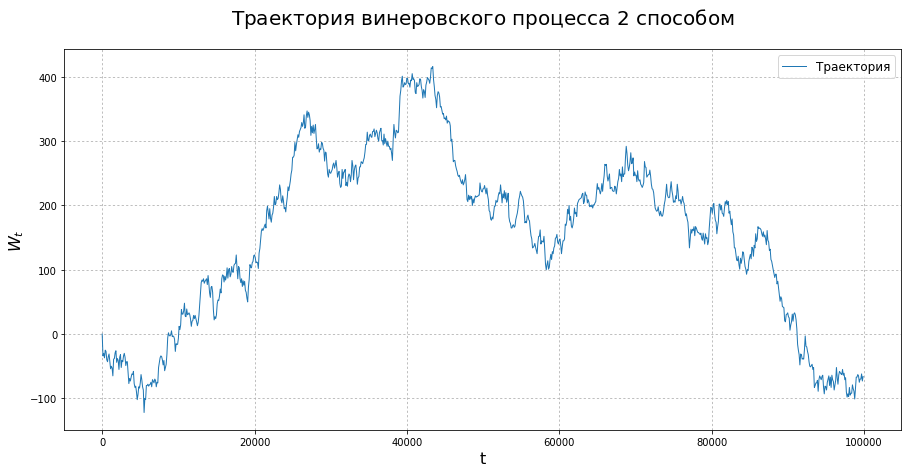

In [56]:
plt.figure(figsize=(15, 7))

times, values = winer_process_path_2(100000, 100)
    
plt.plot(times, values, label="Траектория", lw=1)
plt.title("Траектория винеровского процесса $2$ способом", 
          y=1.05, fontsize=20)

plt.legend(fontsize=12, loc='best')
plt.xlabel("t", fontsize=16)
plt.ylabel("$W_t$", fontsize=16)
plt.grid(ls=':')
plt.show()

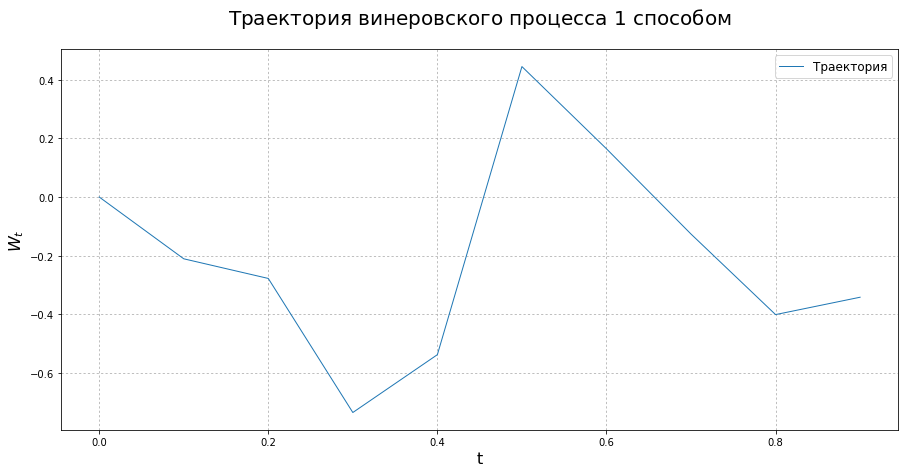

In [69]:
plt.figure(figsize=(15, 7))

times, values = winer_process_path_1(1, 0.1)
    
plt.plot(times, values, label="Траектория", lw=1)
plt.title("Траектория винеровского процесса $1$ способом", 
          y=1.05, fontsize=20)

plt.legend(fontsize=12, loc='best')
plt.xlabel("t", fontsize=16)
plt.ylabel("$W_t$", fontsize=16)
plt.grid(ls=':')
plt.show()

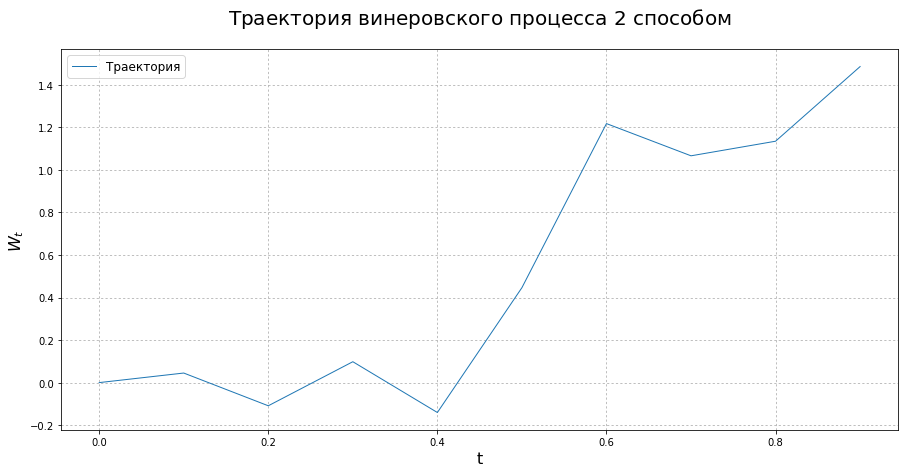

In [71]:
plt.figure(figsize=(15, 7))

times, values = winer_process_path_2(1, 0.1)
    
plt.plot(times, values, label="Траектория", lw=1)
plt.title("Траектория винеровского процесса $2$ способом", 
          y=1.05, fontsize=20)

plt.legend(fontsize=12, loc='best')
plt.xlabel("t", fontsize=16)
plt.ylabel("$W_t$", fontsize=16)
plt.grid(ls=':')
plt.show()

Можно убедиться, что визуально способы не отличимы

**Следующая часть работы делается индивидуально.**

1. Сгенерируйте 100 траекторий винеровского процесса с достаточно хорошей точностью и нарисуйте их на одном графике? Что можно сказать про поведение траекторий?

2. Нарисуйте график двумерного винеровского процесса (см. презентацию с семинара).

In [79]:
ws = []
for i in range(100):
    print(i, end=' ')
    ws.append(winer_process_path_2(10000, 1))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

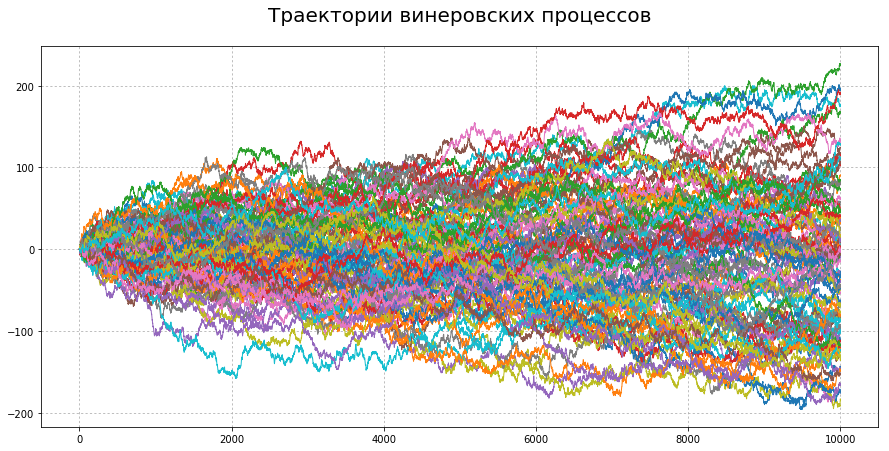

In [122]:
plt.figure(figsize=(15, 7))

times = np.linspace(0, 10000, 500)

for w in ws:
    plt.plot(w[0], w[1], lw=1)
plt.title("Траектории винеровских процессов", 
          y=1.05, fontsize=20)

# plt.legend(fontsize=12, loc='best')
plt.grid(ls=':')
plt.show()

Траектории не уходят далеко от $0$ поскольку вероятность генерации чисел симметрична относительно него.

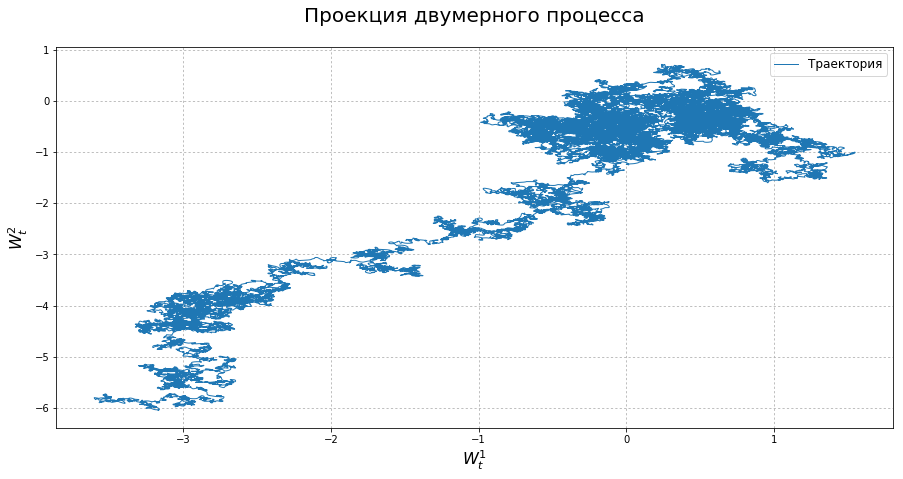

In [123]:
plt.figure(figsize=(15, 7))

times, values1 = winer_process_path_2(10, 0.0001)
times, values2 = winer_process_path_2(10, 0.0001)
    
plt.plot(values1, values2, label="Траектория", lw=1)
plt.title("Проекция двумерного процесса", 
          y=1.05, fontsize=20)

plt.legend(fontsize=12, loc='best')
plt.xlabel("$W_t^1$", fontsize=16)
plt.ylabel("$W_t^2$", fontsize=16)
plt.grid(ls=':')
plt.show()